In [163]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)
effectiveCommentsData$PseudoEffectiveBuilds = log(effectiveCommentsData$PseudoEffectiveBuilds + 1)

effectiveCommentsData$PEBuildsEComments = effectiveCommentsData$PseudoEffectiveBuilds + effectiveCommentsData$EffectiveComments

summary(effectiveCommentsData)

 EffectiveComments PseudoEffectiveBuilds TotalReviewComments
 Min.   :0.00000   Min.   :0.00000       Min.   :0.0000     
 1st Qu.:0.00000   1st Qu.:0.00000       1st Qu.:0.0000     
 Median :0.00000   Median :0.00000       Median :0.0000     
 Mean   :0.08597   Mean   :0.03772       Mean   :0.3024     
 3rd Qu.:0.00000   3rd Qu.:0.00000       3rd Qu.:0.0000     
 Max.   :5.56068   Max.   :4.09434       Max.   :6.0426     
                                                            
 TotalReviewCommentThreads ShareReviewComments GeneralComments 
 Min.   :0.0000            Min.   :  0.00      Min.   :0.0000  
 1st Qu.:0.0000            1st Qu.:  0.00      1st Qu.:0.0000  
 Median :0.0000            Median :  0.00      Median :0.6931  
 Mean   :0.2791            Mean   : 10.47      Mean   :0.8914  
 3rd Qu.:0.0000            3rd Qu.:  0.00      3rd Qu.:1.3863  
 Max.   :6.0039            Max.   :100.00      Max.   :6.9431  
                                                               


In [172]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

hasPseudoEffectiveBuilds <- sqldf("select * 
                        from 'effectiveCommentsData'
                        where PseudoEffectiveBuilds > 0")

hasPEBuildsEComments <- sqldf("select * 
                        from 'effectiveCommentsData'
                        where PEBuildsEComments > 0")

hasEffectiveComments <- hasEffectiveComments[hasEffectiveComments$EffectiveComments < quantile(hasEffectiveComments$EffectiveComments, 0.95), ]
hasPEBuildsEComments <- hasPEBuildsEComments[hasPEBuildsEComments$PEBuildsEComments < quantile(hasPEBuildsEComments$PEBuildsEComments, 0.95), ]

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

no_linter_static = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'static'))
linter_static = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'static'))

no_linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'dynamic'))
linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'dynamic'))


print(no_linter_static)
print(linter_static)

print(no_linter_dynamic)
print(linter_dynamic)

[1] 20319


 EffectiveComments PseudoEffectiveBuilds TotalReviewComments
 Min.   :0.6931    Min.   :0.0000        Min.   :0.6931     
 1st Qu.:0.6931    1st Qu.:0.0000        1st Qu.:1.0986     
 Median :1.0986    Median :0.0000        Median :1.6094     
 Mean   :1.1978    Mean   :0.1321        Mean   :1.7767     
 3rd Qu.:1.6094    3rd Qu.:0.0000        3rd Qu.:2.3026     
 Max.   :2.7081    Max.   :3.6889        Max.   :5.2832     
                                                            
 TotalReviewCommentThreads ShareReviewComments GeneralComments 
 Min.   :0.6931            Min.   :  1.19      Min.   :0.0000  
 1st Qu.:1.0986            1st Qu.: 33.33      1st Qu.:0.6931  
 Median :1.6094            Median : 57.14      Median :1.3863  
 Mean   :1.6474            Mean   : 57.09      Mean   :1.5461  
 3rd Qu.:2.1972            3rd Qu.: 79.17      3rd Qu.:2.1972  
 Max.   :5.2832            Max.   :100.00      Max.   :5.3753  
                                                               


[1] 2171
[1] 4486
[1] 4827
[1] 5639


In [168]:
determineImpact <- function(model, trainingData, target, interested_in) {        
    numVals = 0
    
    meanVals <- data.frame()

    if(class(trainingData[[interested_in]]) != 'factor'){
        print("Cannot do this for a non-factor")
        return
    } else {
        numVals = length(levels(trainingData[[interested_in]]))

        meanVals <- data.frame(matrix(ncol=1, nrow=numVals))
        
        colnames(meanVals)<- c(interested_in)
        
        meanVals[[interested_in]] = levels(trainingData[[interested_in]])
    }
    
    
    for(columnName in all.vars(as.formula(model))) {
        if(columnName == target) {
            next
        }
        if(columnName == interested_in) {
            next
        }
        
        if(class(trainingData[[columnName]]) == 'factor') {
            meanVals[[columnName]] = rep(c(levels(trainingData[[columnName]])[1]), numVals)
        } else {
            meanVals[[columnName]] = rep(c(median(trainingData[[columnName]])), numVals)
        }
    }
    
    print(meanVals)
    
    
    print("Order is: ")
    print(meanVals[[interested_in]])
    
    print("Predict is:")
    print(predict(model, meanVals, type="response"))
}

# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [169]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0 and LanguageType != "unk"')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))),]

combined <- rbind(sampledZerosdf, sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))

baseHurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModel)
r.squaredGLMM(baseHurdleModel)
vif(baseHurdleModel)
anova(baseHurdleModel)

determineImpact(baseHurdleModel, combined, 'EffectiveComments', 'IsAfter')


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4213  -0.5566  -0.0157   0.6530   2.8143  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.86069    0.15612 -37.541  < 2e-16 ***
Additions                      0.21483    0.01236  17.379  < 2e-16 ***
Deletions                     -0.09866    0.01215  -8.118 4.74e-16 ***
IsMergedTrue                   0.78974    0.03644  21.675  < 2e-16 ***
Commits                        1.39742    0.02832  49.341  < 2e-16 ***
LinterTrue                    -0.02705    0.03139  -0.862    0.389    
CoverageTrue              

R2m       R2c 
0.6467156 0.6467156

Additions                     Deletions 
                     3.298128                      2.632335 
                     IsMerged                       Commits 
                     1.155259                      1.409046 
                       Linter                      Coverage 
                     1.042225                      1.111881 
                    Assignees                  ChangedFiles 
                     1.042840                      3.804187 
             NumOfUniqueUsers                     PRsOpened 
                     2.298605                      2.943032 
                  TotalBuilds                NewContributor 
                     3.012935                      1.770740 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.739050                      1.868401 
              GeneralComments                  LanguageType 
                     2.319758                      1.193540 
                      IsAfter 
                     3.627036

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,34245,47475.04
Additions,1,3.190100e+03,34244,44284.94
Deletions,1,1.332413e+02,34243,44151.70
IsMerged,1,3.187643e+01,34242,44119.82
Commits,1,7.406441e+03,34241,36713.38
Linter,1,1.204882e+01,34240,36701.33
Coverage,1,4.213537e+00,34239,36697.12
Assignees,1,1.976655e+02,34238,36499.45
ChangedFiles,1,2.089714e+02,34237,36290.48
NumOfUniqueUsers,1,7.320944e+03,34236,28969.53


  IsAfter Additions Deletions IsMerged  Commits Linter Coverage Assignees
1   False  3.218876  1.609438    False 1.098612  False    False         0
2    True  3.218876  1.609438    False 1.098612  False    False         0
  ChangedFiles NumOfUniqueUsers PRsOpened TotalBuilds NewContributor
1     1.098612         1.098612  2.995732           0          False
2     1.098612         1.098612  2.995732           0          False
  PrOpenedDaysAfterProjectStart FromOutsider GeneralComments LanguageType
1                      7.046647        False        1.098612      dynamic
2                      7.046647        False        1.098612      dynamic
[1] "Order is: "
[1] "False" "True" 
[1] "Predict is:"
        1         2 
0.3513304 0.2161898 


# Interaction between LanguageType and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4850  -0.4888  -0.0124   0.5624   3.0908  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -8.40671    0.55064 -15.267  < 2e-16 ***
Additions                       0.23944    0.04369   5.481 4.23e-08 ***
Deletions                      -0.09954    0.04279  -2.326  0.02002 *  
IsMergedTrue                    1.27307    0.14500   8.780  < 2e-16 ***
Commits                         1.38807    0.09470  14.658  < 2e-16 ***
LinterTrue                      0.07577    0.11607   0.653  0.51386    
CoverageTrue       

R2m       R2c 
0.7013595 0.7013595

Additions                     Deletions 
                     3.155901                      2.701149 
                     IsMerged                       Commits 
                     1.183359                      1.564220 
                       Linter                      Coverage 
                     1.192139                      1.318830 
                    Assignees                  ChangedFiles 
                     1.081146                      3.776221 
             NumOfUniqueUsers                     PRsOpened 
                     2.880763                      3.435962 
                  TotalBuilds                NewContributor 
                     3.199675                      1.827242 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     2.494727                      2.462620 
              GeneralComments                  LanguageType 
                     3.013387                      2.635672 
                      IsAfter          LanguageType:IsAfter 
                     5.142417                      3.268711

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,353.7323252,3094,3938.235
Deletions,1,4.4698492,3093,3933.765
IsMerged,1,27.7215718,3092,3906.044
Commits,1,785.5542807,3091,3120.489
Linter,1,4.6664645,3090,3115.823
Coverage,1,10.8741803,3089,3104.949
Assignees,1,0.5392587,3088,3104.409
ChangedFiles,1,19.0129706,3087,3085.396
NumOfUniqueUsers,1,543.6572170,3086,2541.739


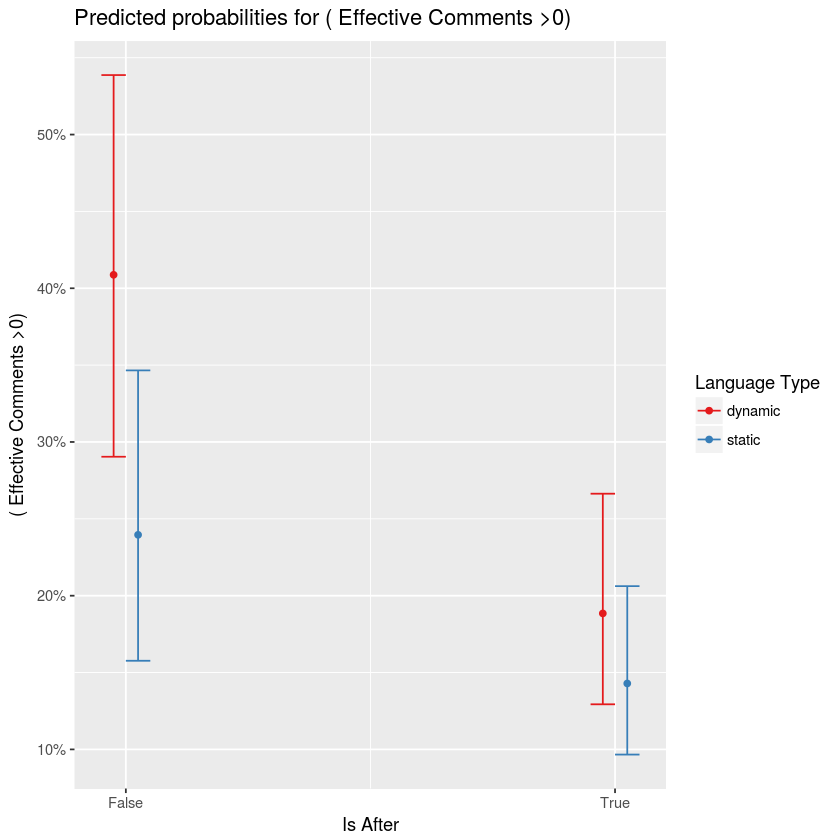

In [10]:
baseHurdleModelInteraction = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModelInteraction)
r.squaredGLMM(baseHurdleModelInteraction)
vif(baseHurdleModelInteraction)
anova(baseHurdleModelInteraction)

plot_model(baseHurdleModelInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Interaction between Coverage usage and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4628  -0.4914  -0.0122   0.5584   2.9732  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -8.46746    0.55088 -15.371  < 2e-16 ***
Additions                      0.23243    0.04360   5.330 9.80e-08 ***
Deletions                     -0.10182    0.04290  -2.373 0.017637 *  
IsMergedTrue                   1.28870    0.14489   8.894  < 2e-16 ***
Commits                        1.38871    0.09471  14.663  < 2e-16 ***
LinterTrue                     0.05806    0.11609   0.500 0.616989    
Assignees                 

R2m       R2c 
0.7032095 0.7032095

Additions                     Deletions 
                     3.143027                      2.709160 
                     IsMerged                       Commits 
                     1.184804                      1.569231 
                       Linter                     Assignees 
                     1.190876                      1.078373 
                 ChangedFiles              NumOfUniqueUsers 
                     3.789917                      2.850307 
                    PRsOpened                   TotalBuilds 
                     3.443627                      3.181598 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.825836                      2.451716 
                 FromOutsider               GeneralComments 
                     2.464427                      2.964742 
                 LanguageType                      Coverage 
                     1.230885                      2.655634 
                      IsAfter              Coverage:IsAfter 
                     4.775307                      2.976501

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,353.7323252,3094,3938.235
Deletions,1,4.4698492,3093,3933.765
IsMerged,1,27.7215718,3092,3906.044
Commits,1,785.5542807,3091,3120.489
Linter,1,4.6664645,3090,3115.823
Assignees,1,0.9779944,3089,3114.845
ChangedFiles,1,17.0850600,3088,3097.760
NumOfUniqueUsers,1,494.8258877,3087,2602.934
PRsOpened,1,1.3233902,3086,2601.611


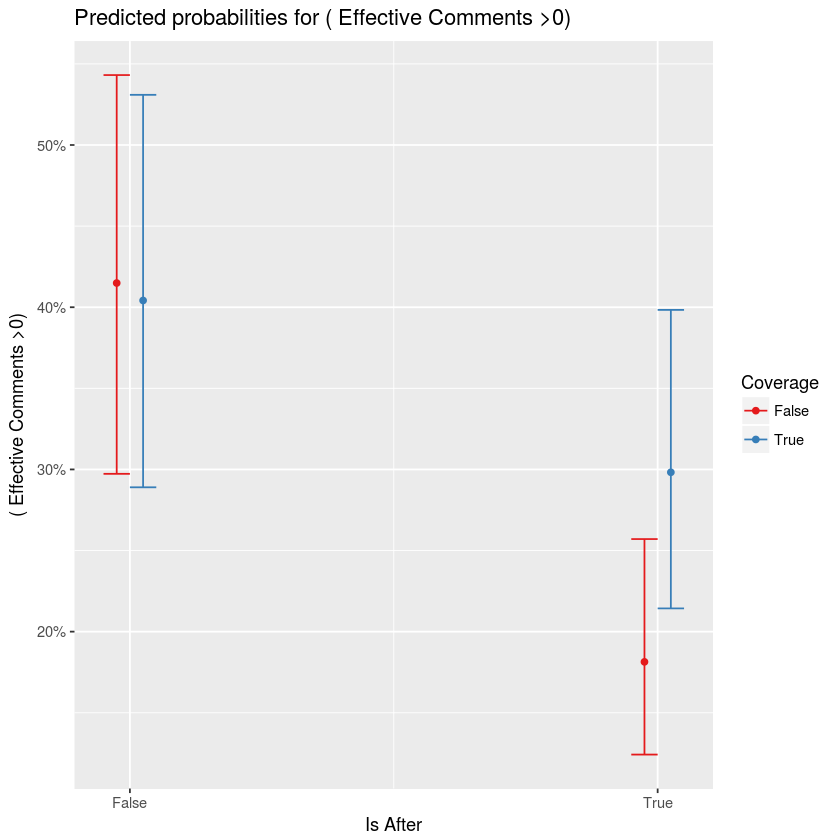

In [11]:
hurdleModelInteractionCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverage)
r.squaredGLMM(hurdleModelInteractionCoverage)
vif(hurdleModelInteractionCoverage)
anova(hurdleModelInteractionCoverage)

plot_model(hurdleModelInteractionCoverage, type="pred", terms=c('IsAfter', 'Coverage'))

# Interaction Linter with Travis Introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.5010  -0.4956  -0.0139   0.5652   3.0494  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -8.45584    0.55766 -15.163  < 2e-16 ***
Additions                      0.23397    0.04356   5.372 7.81e-08 ***
Deletions                     -0.10199    0.04283  -2.381 0.017258 *  
IsMergedTrue                   1.27648    0.14477   8.817  < 2e-16 ***
Commits                        1.38144    0.09461  14.602  < 2e-16 ***
CoverageTrue                   0.34853    0.12404   2.810 0.004959 ** 
Assignees                 

R2m       R2c 
0.7007207 0.7007207

Additions                     Deletions 
                     3.145683                      2.708717 
                     IsMerged                       Commits 
                     1.186617                      1.561360 
                     Coverage                     Assignees 
                     1.312381                      1.077528 
                 ChangedFiles              NumOfUniqueUsers 
                     3.786084                      2.868435 
                    PRsOpened                   TotalBuilds 
                     3.473579                      3.164633 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.844992                      2.426278 
                 FromOutsider               GeneralComments 
                     2.497953                      2.988533 
                 LanguageType                        Linter 
                     1.237783                      2.496877 
                      IsAfter                Linter:IsAfter 
                     4.532903                      3.081317

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,353.7323252,3094,3938.235
Deletions,1,4.4698492,3093,3933.765
IsMerged,1,27.7215718,3092,3906.044
Commits,1,785.5542807,3091,3120.489
Coverage,1,12.8024304,3090,3107.687
Assignees,1,0.4398581,3089,3107.247
ChangedFiles,1,17.9623948,3088,3089.285
NumOfUniqueUsers,1,543.3455359,3087,2545.939
PRsOpened,1,1.2438957,3086,2544.695


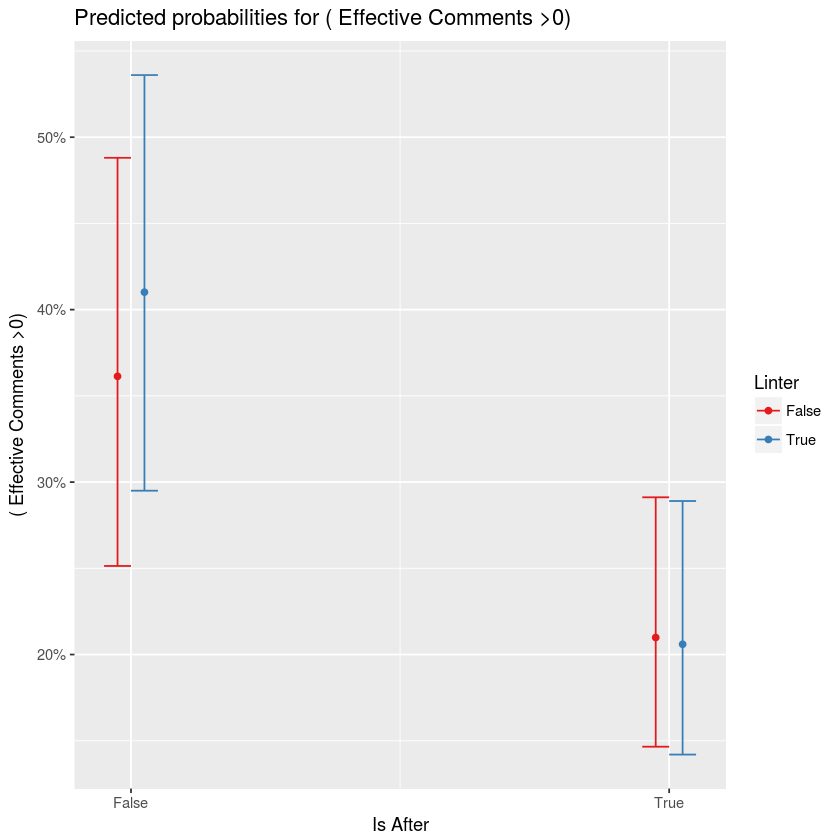

In [12]:
hurdleModelInteractionLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLinter)
r.squaredGLMM(hurdleModelInteractionLinter)
vif(hurdleModelInteractionLinter)
anova(hurdleModelInteractionLinter)

plot_model(hurdleModelInteractionLinter, type="pred", terms=c('IsAfter', 'Linter'))

# Interaction between coverage, linter and Travis introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType + Coverage * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4815  -0.4843  -0.0129   0.5550   2.9870  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -8.61261    0.57647 -14.940  < 2e-16 ***
Additions                            0.23034    0.04367   5.275 1.33e-07 ***
Deletions                           -0.10322    0.04298  -2.401 0.016337 *  
IsMergedTrue                         1.28543    0.14507   8.861  < 2e-16 ***
Commits                              1.38499    0.09493  14.590  < 2e-16 ***
Assignees                           -0.22513    0.28968  -0.7

R2m       R2c 
0.7033482 0.7033482

Additions                     Deletions 
                     3.147742                      2.716776 
                     IsMerged                       Commits 
                     1.188451                      1.571903 
                    Assignees                  ChangedFiles 
                     1.101288                      3.808523 
             NumOfUniqueUsers                     PRsOpened 
                     2.860296                      3.528925 
                  TotalBuilds                NewContributor 
                     3.250190                      1.850392 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     3.311537                      2.514912 
              GeneralComments                  LanguageType 
                     2.982723                      2.672444 
                     Coverage                        Linter 
                     7.058228                      4.264252 
                      IsAfter               Coverage:Linter 
                     6.347777                      8.215658 
             Coverage:IsAfter                Linter:IsAfter 
                     5.313780                      5.089284 
      Coverage:Linter:IsAfter 
                     5.837975

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,353.73232517,3094,3938.235
Deletions,1,4.46984923,3093,3933.765
IsMerged,1,27.72157180,3092,3906.044
Commits,1,785.55428074,3091,3120.489
Assignees,1,0.84405179,3090,3119.645
ChangedFiles,1,15.63566726,3089,3104.010
NumOfUniqueUsers,1,491.25802037,3088,2612.752
PRsOpened,1,3.39217482,3087,2609.359
TotalBuilds,1,114.45675137,3086,2494.903


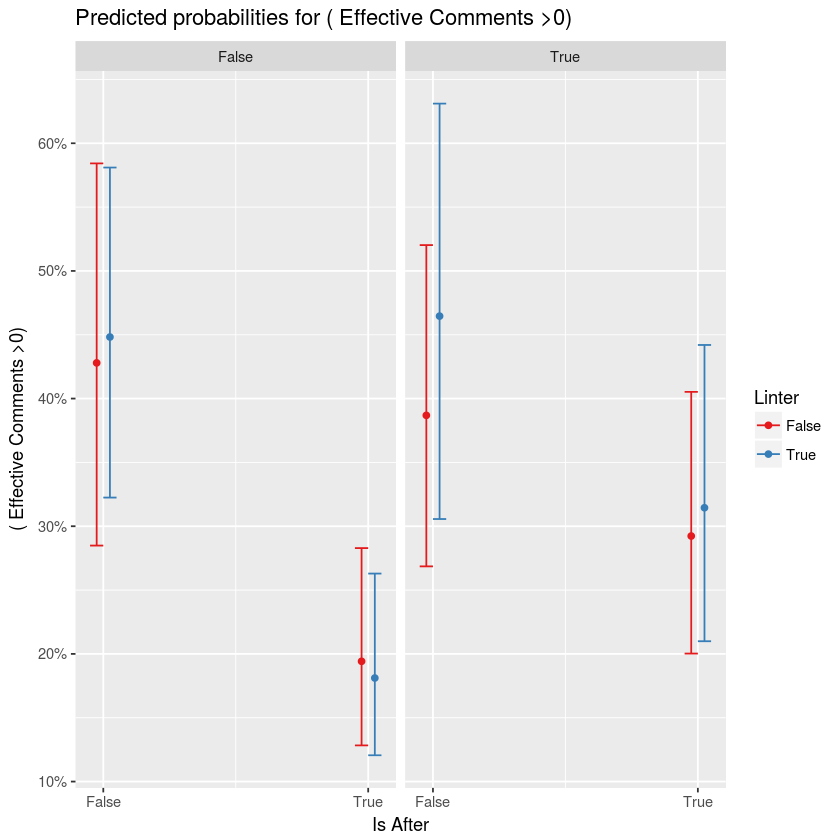

In [13]:
hurdleModelInteractionCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                           Coverage*
                                         Linter*
            IsAfter ,
          data=combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverageLinter)
r.squaredGLMM(hurdleModelInteractionCoverageLinter)
vif(hurdleModelInteractionCoverageLinter)
anova(hurdleModelInteractionCoverageLinter)

plot_model(hurdleModelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Linter', 'Coverage'))

# Interaction between language type, linter and travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Coverage + LanguageType * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4561  -0.4831  -0.0104   0.5571   2.8795  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -8.98375    0.58835 -15.269  < 2e-16
Additions                                  0.24273    0.04392   5.527 3.25e-08
Deletions                                 -0.11191    0.04324  -2.588  0.00964
IsMergedTrue                               1.18639    0.14627   8.111 5.03e-16
Commits                                    1.37816    0.09565  14.409  < 2e-16
Assignees                                 -0.1460

R2m       R2c 
0.7128907 0.7128907

Additions                     Deletions 
                     3.103844                      2.710520 
                     IsMerged                       Commits 
                     1.195281                      1.578919 
                    Assignees                  ChangedFiles 
                     1.087917                      3.825033 
             NumOfUniqueUsers                     PRsOpened 
                     2.894886                      3.580173 
                  TotalBuilds                NewContributor 
                     3.159763                      1.851735 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     2.563153                      2.560551 
              GeneralComments                      Coverage 
                     3.019405                      2.321416 
                 LanguageType                        Linter 
                     5.865540                      5.327928 
                      IsAfter           LanguageType:Linter 
                     5.730677                      9.332981 
         LanguageType:IsAfter                Linter:IsAfter 
                     5.962913                      5.877222 
  LanguageType:Linter:IsAfter 
                     7.866588

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,353.7323252,3094,3938.235
Deletions,1,4.4698492,3093,3933.765
IsMerged,1,27.7215718,3092,3906.044
Commits,1,785.5542807,3091,3120.489
Assignees,1,0.8440518,3090,3119.645
ChangedFiles,1,15.6356673,3089,3104.010
NumOfUniqueUsers,1,491.2580204,3088,2612.752
PRsOpened,1,3.3921748,3087,2609.359
TotalBuilds,1,114.4567514,3086,2494.903


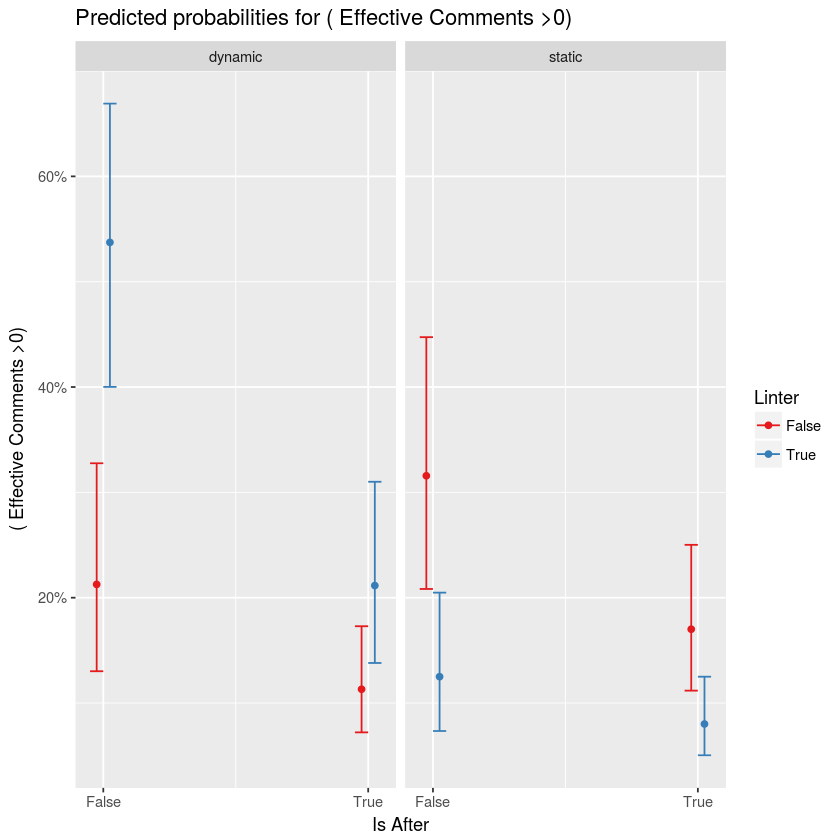

In [14]:
hurdleModelInteractionLanguageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Coverage +
            LanguageType *
            Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageLinter)
vif(hurdleModelInteractionLanguageLinter)
anova(hurdleModelInteractionLanguageLinter)

plot_model(hurdleModelInteractionLanguageLinter, type="pred", terms=c('IsAfter', 'Linter', 'LanguageType'))

# Interaction between langauge type, coverage and Travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Linter + LanguageType * 
    Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4475  -0.4866  -0.0117   0.5600   3.0813  

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                                 -8.80523    0.57311 -15.364
Additions                                    0.23281    0.04388   5.305
Deletions                                   -0.10403    0.04304  -2.417
IsMergedTrue                                 1.26108    0.14582   8.648
Commits                                      1.38252    0.09553  14.472
Assignees                                   -0.24653    0.28939  -0.852
ChangedFiles       

R2m       R2c 
0.7049827 0.7049827

Additions                     Deletions 
                     3.147005                      2.702838 
                     IsMerged                       Commits 
                     1.191017                      1.580747 
                    Assignees                  ChangedFiles 
                     1.089877                      3.791860 
             NumOfUniqueUsers                     PRsOpened 
                     2.863586                      3.488532 
                  TotalBuilds                NewContributor 
                     3.249408                      1.832970 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     3.467000                      2.506641 
              GeneralComments                        Linter 
                     3.019502                      2.150617 
                 LanguageType                      Coverage 
                     6.196979                      7.382266 
                      IsAfter         LanguageType:Coverage 
                     8.017584                      9.092255 
         LanguageType:IsAfter              Coverage:IsAfter 
                     5.670829                      5.404508 
LanguageType:Coverage:IsAfter 
                     5.799851

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,3095,4291.967
Additions,1,3.537323e+02,3094,3938.235
Deletions,1,4.469849e+00,3093,3933.765
IsMerged,1,2.772157e+01,3092,3906.044
Commits,1,7.855543e+02,3091,3120.489
Assignees,1,8.440518e-01,3090,3119.645
ChangedFiles,1,1.563567e+01,3089,3104.010
NumOfUniqueUsers,1,4.912580e+02,3088,2612.752
PRsOpened,1,3.392175e+00,3087,2609.359
TotalBuilds,1,1.144568e+02,3086,2494.903


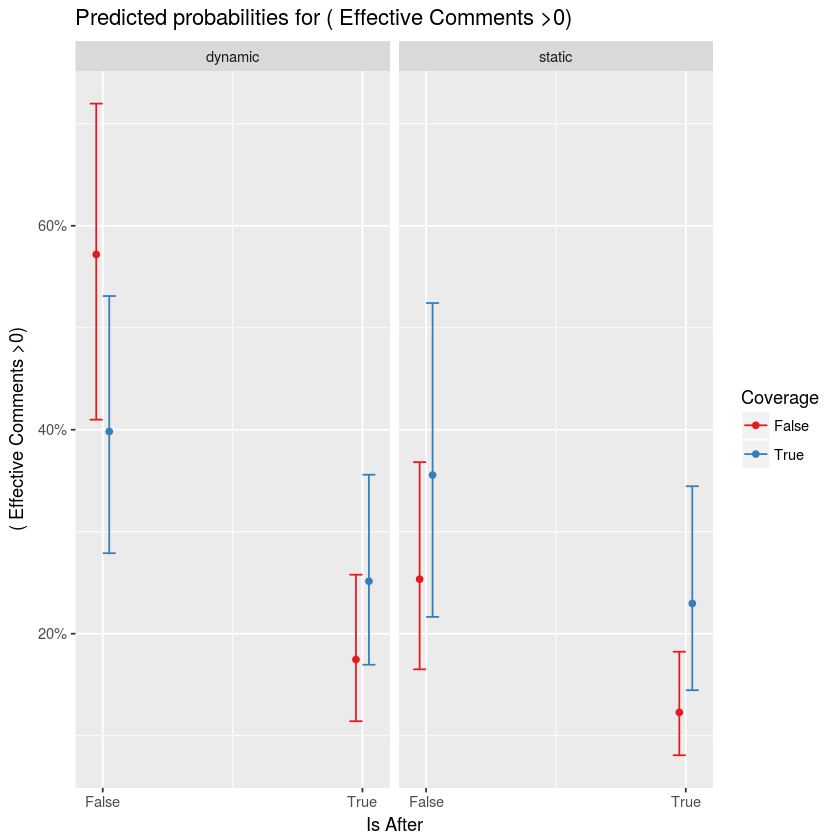

In [15]:
hurdleModelInteractionLanguageCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Linter +
            LanguageType *
            Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverage)
r.squaredGLMM(hurdleModelInteractionLanguageCoverage)
vif(hurdleModelInteractionLanguageCoverage)
anova(hurdleModelInteractionLanguageCoverage)

plot_model(hurdleModelInteractionLanguageCoverage, type="pred", terms=c('IsAfter', 'Coverage', 'LanguageType'))

# Interaction between language type, coverage and linter (no travis!)

In [16]:
hurdleModelInteractionLanguageCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            Linter*
            Coverage+
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageCoverageLinter)
vif(hurdleModelInteractionLanguageCoverageLinter)
anova(hurdleModelInteractionLanguageCoverageLinter)

plot_model(hurdleModelInteractionLanguageCoverageLinter, type="pred", terms=c('Linter', 'Coverage', 'LanguageType'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType * Linter * 
    Coverage + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4332  -0.4779  -0.0096   0.5420   2.8699  

Coefficients: (1 not defined because of singularities)
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -8.56522    0.56883 -15.057  < 2e-16
Additions                                   0.24133    0.04403   5.481 4.24e-08
Deletions                                  -0.10970    0.04338  -2.529 0.011437
IsMergedTrue                                1.17681    0.14612   8.054 8.04e-16
Commits                                     1.35309    0.09572  14.136  < 2e-16
As

R2m R2c 
 NA  NA

ERROR: Error in vif.default(hurdleModelInteractionLanguageCoverageLinter): there are aliased coefficients in the model


# Linear models!

In [139]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [170]:
summary(hasEffectiveComments$EffectiveComments)

baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            #CommitsAfterCreate + 
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            IsAfter ,
        hasEffectiveComments)

determineImpact(baseModel, hasEffectiveComments, 'EffectiveComments', 'IsAfter')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6931  0.6931  1.0986  1.1978  1.6094  2.7081 


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2584 -0.3943 -0.1126  0.3202  1.7319 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.996777   0.038310  26.019  < 2e-16 ***
Additions                      0.058020   0.002803  20.703  < 2e-16 ***
Deletions                     -0.017815   0.002621  -6.798 1.09e-11 ***
IsMergedTrue                  -0.004578   0.009178  -0.499  0.61789    
Assignees                      0.040991   0.015606   2.627  0.00863 ** 
LinterTrue                    -0.002662   0.007327  -0.363  0.71638    
CoverageTrue                   0.014151   0.007490   1.889  0.05887 .  
ChangedFiles                  -0.011490   0.006248  -1.839  0.06595 .  
NumOfUniqueUsers               0.228030   0.013712  16.630  < 2e-16 ***
PRsOpened                     -0.014795   0.003036  -4.874 1.10e-06 ***
TotalBuilds                    0.103027   0.006596  15.61

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [150]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
")
        )



determineImpact(ltypeModel, sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"), 'EffectiveComments', 'IsAfter')


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68709 -0.30579 -0.03544  0.27297  1.02012 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.928067   0.031361  29.593  < 2e-16 ***
Additions                      0.024327   0.002352  10.343  < 2e-16 ***
Deletions                     -0.007509   0.002223  -3.378 0.000732 ***
IsMergedTrue                  -0.007954   0.007449  -1.068 0.285601    
Assignees                      0.022410   0.012992   1.725 0.084563 .  
LinterTrue                     0.001786   0.006113   0.292 0.770190    
CoverageTrue                  -0.001567   0.006311  -0.248 0.803947    
ChangedFiles                   0.003324   0.005197   0.640 0.522507    
NumOfUniqueUsers               0.135340   0.011474  11.796  < 2e-16 ***
PRsOpened                     -0.003855   0.002493  -1.546 0.122069    
TotalBuilds                    0.046901   0.005

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 

In [ ]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Linter +
            Coverage +
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Finding projects that experience more effect from Travis

In [63]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

projectResults = data.frame(ProjectName=character(),
                            PRs = integer(),
                           PValue=double(),
                            R2=double(),
                           Coefficient=double(),
                           PercentageExplained=double(),
                            ModelType=character(),
                           stringsAsFactors=FALSE)

for(project in projectNames) {
        formula <- EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    data <- sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project))
    
    data$IsMerged <- factor(data$IsMerged)
    data$NewContributor <- factor(data$NewContributor)
    data$FromOutsider <- factor(data$FromOutsider)
    data$IsAfter <- factor(data$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(data$IsMerged) > 1 &
      nlevels(data$NewContributor) > 1 &
      nlevels(data$FromOutsider) > 1 &
      nlevels(data$IsAfter) > 1)
    {    
        model_per_project <- lm(formula, data=data)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
        
            av <- anova(model_per_project)
            
            isAfterSum <- av$"Sum Sq"[length(av$"Sum Sq")]
        
            total <- 0
            for(sQrs in av$"Sum Sq") {
                total = sQrs + total
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(data),
                           PValue=pOfIsAfter,
                            R2=summary(model_per_project)$r.squared,
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Non-Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”

In [64]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

for(project in projectNames) {
        formula <- (EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    zerosdf_project <- sqldf(sprintf('select * from "effectiveCommentsData" where EffectiveComments = 0 and ProjectName="%s"',project))

    sampledZerosdf_project <- zerosdf_project[sample(nrow(zerosdf_project), nrow(sqldf(sprintf('select * from hasEffectiveComments where ProjectName="%s"', project)))),]

    combined_project <- rbind(sampledZerosdf_project, sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project)))

    
    combined_project$IsMerged <- factor(combined_project$IsMerged)
    combined_project$NewContributor <- factor(combined_project$NewContributor)
    combined_project$FromOutsider <- factor(combined_project$FromOutsider)
    combined_project$IsAfter <- factor(combined_project$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(combined_project$IsMerged) > 1 &
      nlevels(combined_project$NewContributor) > 1 &
      nlevels(combined_project$FromOutsider) > 1 &
      nlevels(combined_project$IsAfter) > 1)
    {    
        model_per_project <- glm(formula, data=combined_project)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
            
            if(is.na(pOfIsAfter)) {
                next
            }
            
            av = anova(model_per_project)
            
            isAfterSum <- av$Deviance[length(av$Deviance)]
        
            total <- 0
            for(sQrs in av$Deviance) {
                if( !is.na(sQrs)) {
                total = sQrs + total
                    }
            }
            
            if(total == 0) {
                next
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(combined_project),
                           PValue=pOfIsAfter,
                            R2=r.squaredGLMM(model_per_project)[["R2m"]],
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

In [65]:


write.csv(projectResults, file = "generated/coefficients.csv",row.names=FALSE, na="")

# How about PEBuilds

This is at first just sanity checking, then we look at the combo of PEBuilds and effective comments. 

In [45]:
peBaseModel <- executeLmOnData(
            PseudoEffectiveBuilds ~ 
            EffectiveComments + 
            #Additions + 
            #Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            CommitsAfterCreate + 
            Coverage +
            #ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            #TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments +
            LanguageType + 
            TotalReviewComments,
        hasPseudoEffectiveBuilds)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78029 -0.18102 -0.08685  0.01971  3.14968 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.970202   0.056391  17.205  < 2e-16 ***
EffectiveComments              0.003342   0.006878   0.486 0.627109    
IsMergedTrue                  -0.195325   0.007658 -25.505  < 2e-16 ***
Assignees                     -0.051911   0.015120  -3.433 0.000598 ***
LinterTrue                     0.003619   0.007222   0.501 0.616348    
CommitsAfterCreate             0.091528   0.003938  23.241  < 2e-16 ***
CoverageTrue                   0.031501   0.007254   4.343 1.42e-05 ***
NumOfUniqueUsers              -0.145949   0.010414 -14.015  < 2e-16 ***
PRsOpened                     -0.009517   0.002646  -3.597 0.000323 ***
NewContributorTrue             0.051635   0.011941   4.324 1.54e-05 ***
PrOpenedDaysAfterProjectStart  0.007990   0.007

In [173]:
peBaseModel <- executeLmOnData(
            PEBuildsEComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            Linter +
            CommitsAfterCreate + 
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments +
            LanguageType + 
            TotalReviewComments + 
            IsAfter,
        hasPEBuildsEComments)



determineImpact(peBaseModel, hasPEBuildsEComments, 'PEBuildsEComments', 'IsAfter')


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.62184 -0.25317 -0.00717  0.20565  1.53587 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.7978617  0.0277987  28.701  < 2e-16 ***
Additions                      0.0069521  0.0018358   3.787 0.000153 ***
Deletions                     -0.0302161  0.0017582 -17.186  < 2e-16 ***
IsMergedTrue                  -0.0006160  0.0059871  -0.103 0.918049    
Commits                        0.0585490  0.0048491  12.074  < 2e-16 ***
Assignees                     -0.0309178  0.0106891  -2.892 0.003825 ** 
LinterTrue                     0.0076221  0.0053397   1.427 0.153463    
CommitsAfterCreate             0.0008991  0.0042256   0.213 0.831495    
CoverageTrue                   0.0131351  0.0054193   2.424 0.015366 *  
ChangedFiles                   0.0263532  0.0039777   6.625 3.52e-11 ***
NumOfUniqueUsers              -0.100

# Predicting the number of Commits After Create

In [177]:
hasCommitsAfterCreate <- sqldf("select * from effectiveCommentsData where CommitsAfterCreate > 0")

hasCommitsAfterCreate <- hasCommitsAfterCreate[hasCommitsAfterCreate$CommitsAfterCreate < quantile(hasCommitsAfterCreate$CommitsAfterCreate, 0.95), ]

baseModel <- executeLmOnData(
            CommitsAfterCreate ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage + 
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            TotalReviewComments +
            IsAfter ,
            hasCommitsAfterCreate
        )

determineImpact(baseModel, hasCommitsAfterCreate, 'CommitsAfterCreate', 'IsAfter')


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1241 -0.2990 -0.1354  0.2281  1.9672 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.0332253  0.0136764  75.548  < 2e-16 ***
Additions                      0.0282488  0.0009432  29.951  < 2e-16 ***
Deletions                      0.0151657  0.0010191  14.881  < 2e-16 ***
IsMergedTrue                  -0.0409442  0.0035440 -11.553  < 2e-16 ***
Assignees                      0.0693996  0.0071975   9.642  < 2e-16 ***
LinterTrue                    -0.0066307  0.0030475  -2.176   0.0296 *  
CoverageTrue                  -0.0002858  0.0031294  -0.091   0.9272    
PRsOpened                     -0.0076783  0.0012098  -6.347 2.21e-10 ***
TotalBuilds                    0.3223986  0.0035170  91.670  < 2e-16 ***
NewContributorTrue            -0.0066447  0.0053451  -1.243   0.2138    
PrOpenedDaysAfterProjectStart -0.0170462  0.00

In [176]:
hasAdditions <- sqldf("select * from effectiveCommentsData where Additions > 0")

hasAdditions <- hasAdditions[hasAdditions$Additions < quantile(hasAdditions$Additions, 0.95), ]

baseModel <- executeLmOnData(
            Additions ~ 
            IsMerged +
            Commits + 
            Assignees + 
            Linter +
            Coverage + 
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments +
            NumOfUniqueUsers +
            CommitsAfterCreate + 
            TotalReviewComments +
            IsAfter ,
        hasAdditions)

determineImpact(baseModel, hasAdditions, 'Additions', 'IsAfter')


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7367 -1.1073 -0.1497  0.9311  4.9393 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    2.144743   0.027891  76.897  < 2e-16 ***
IsMergedTrue                  -0.142686   0.007242 -19.703  < 2e-16 ***
Commits                        1.327841   0.007253 183.073  < 2e-16 ***
Assignees                      0.112001   0.015583   7.187 6.63e-13 ***
LinterTrue                     0.015010   0.005805   2.586  0.00972 ** 
CoverageTrue                   0.034390   0.005992   5.739 9.51e-09 ***
PRsOpened                      0.074223   0.002250  32.988  < 2e-16 ***
TotalBuilds                   -0.189428   0.009479 -19.984  < 2e-16 ***
NewContributorTrue            -0.190874   0.010365 -18.416  < 2e-16 ***
PrOpenedDaysAfterProjectStart -0.109823   0.003854 -28.494  < 2e-16 ***
FromOutsiderTrue              -0.170416   0.007537 -22.60

In [181]:
baseModel <- glm(
            FromOutsider ~ 
            Additions +
            Commits + 
            Assignees + 
            Linter +
            Coverage + 
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            IsMerged + 
            GeneralComments +
            NumOfUniqueUsers +
            CommitsAfterCreate + 
            TotalReviewComments +
    GeneralComments + 
            IsAfter ,
        hasEffectiveComments,
        family='binomial',
control = list(maxit = 100))

summary(baseModel)
r.squaredGLMM(baseModel)
vif(baseModel)
anova(baseModel)


Call:
glm(formula = FromOutsider ~ Additions + Commits + Assignees + 
    Linter + Coverage + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + IsMerged + GeneralComments + 
    NumOfUniqueUsers + CommitsAfterCreate + TotalReviewComments + 
    GeneralComments + IsAfter, family = "binomial", data = hasEffectiveComments, 
    control = list(maxit = 100))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3774  -0.6243   0.1770   0.5823   2.7989  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    3.50114    0.20835  16.804  < 2e-16 ***
Additions                     -0.18529    0.01085 -17.083  < 2e-16 ***
Commits                       -0.27659    0.05070  -5.455 4.89e-08 ***
Assignees                     -0.76969    0.08453  -9.105  < 2e-16 ***
LinterTrue                    -0.05340    0.03990  -1.338 0.180846    
CoverageTrue                   0.13857    0.04073   3.402 

R2m       R2c 
0.6068443 0.6068443

Additions                       Commits 
                     1.395163                      4.203205 
                    Assignees                        Linter 
                     1.026057                      1.031376 
                     Coverage                     PRsOpened 
                     1.034159                      1.248595 
                  TotalBuilds                NewContributor 
                     3.062003                      1.142291 
PrOpenedDaysAfterProjectStart                      IsMerged 
                     1.898562                      1.031908 
              GeneralComments              NumOfUniqueUsers 
                     2.129903                      2.065027 
           CommitsAfterCreate           TotalReviewComments 
                     4.406540                      1.450041 
                      IsAfter 
                     3.549136

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,20318,27154.62
Additions,1,1.217982e+03,20317,25936.64
Commits,1,3.773977e+01,20316,25898.90
Assignees,1,1.975755e+02,20315,25701.33
Linter,1,3.257932e+00,20314,25698.07
Coverage,1,6.212467e+01,20313,25635.94
PRsOpened,1,8.880329e+03,20312,16755.62
TotalBuilds,1,2.121405e+02,20311,16543.48
NewContributor,1,3.809134e+00,20310,16539.67
PrOpenedDaysAfterProjectStart,1,8.624430e+01,20309,16453.42
